# Principal_component_analysis_AGDC.ipynb

This code combines all of the individual datasets used previously into a principal component analysis. NDVI slope, Landsat data and band indices, elevation and gamma data are all extracted and added into the PCA. The first 6 principal components are plotted and then tested for statistical difference based on the palaeovalleys shape file. The significance of each principal component helps to determine which PC best captures palaeovalley location.

** Code dependencies **
- csv file containing the bounding boxes for the case study site/s
- palaeovalleys 2012 shape file
- Landsat band average netcdf files produced by "Extract_AGDC_for_study_sites_looped"
- NDVI slope netcdf files created by "Palaeovalley_NDVI_linear_regression_raijin_JanJun/JulDec.py

** Accompanying code**
- Princical_component_analysis_AGDC_looped.ipynb - loops through all of the case study sites

Created by Claire Krause, Datacube v 1.1.17, python v3

Based on PCA code from Neil Symington

In [1]:
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import geopandas as gp
import datacube
datacube.set_options(reproject_threads=1)
dc = datacube.Datacube(app='PCA')
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import csv
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, Imputer

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)
def write_to_csv(OUTPUT_path, row, idx):
    if idx == 0:
        with open(OUTPUT_path,'w') as csvFile:
            writer = csv.writer(csvFile)
            header = ['name', 'ttest', 'KS_test']
            writer.writerow(header)
            writer.writerow(row)
    else:
        with open(OUTPUT_path,'a') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerow(row)

## Load in the case study areas

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

## Choose a site for our example code

In [4]:
# Choose your site for this example
# Here we will select Blackwood2A, located in row 0
num = 0
Studysite = names.ix[num]
print(Studysite)
site = names.Name[num]

Name      Blackwood2A
minlat          -34.1
maxlat          -33.4
minlon          116.4
maxlon          117.4
Name: 0, dtype: object


# Get the data ready that we want to use in the PCA

### Landsat data

In [5]:
print ('Working on ' + site)
# Set up our file names to be read in
blue_mean = '/g/data/p25/cek156/' + site + '/' + site + '_blue_time_mean.nc'
green_mean = '/g/data/p25/cek156/' + site + '/' + site + '_green_time_mean.nc'
red_mean = '/g/data/p25/cek156/' + site + '/' + site + '_red_time_mean.nc'
nir_mean = '/g/data/p25/cek156/' + site + '/' + site + '_nir_time_mean.nc'
swir1_mean = '/g/data/p25/cek156/' + site + '/' + site + '_swir1_time_mean.nc'
swir2_mean = '/g/data/p25/cek156/' + site + '/' + site + '_swir2_time_mean.nc'

# We need to check that the mean files have been created before we try to read them in
file_checkb = os.path.isfile(blue_mean)
file_checkg = os.path.isfile(green_mean)
file_checkr = os.path.isfile(red_mean)
file_checkn = os.path.isfile(nir_mean)
file_checks1 = os.path.isfile(swir1_mean)
file_checks2 = os.path.isfile(swir2_mean)

# If all the files are then, then we can read them in
if file_checkb == True & file_checkg == True & file_checkr == True & file_checkn == True & file_checks1 == True & file_checks2 == True:
    blue = xr.open_dataset(blue_mean)
    green = xr.open_dataset(green_mean)
    red = xr.open_dataset(red_mean)
    nir = xr.open_dataset(nir_mean)
    swir1 = xr.open_dataset(swir1_mean) 
    swir2 = xr.open_dataset(swir2_mean)

    ########### Set up the analyses you would like to do ###########################
    # Check out http://www.indexdatabase.de/db/i.php for a list of a whole bunch of indices, 
    # as well as their platform specific formulas (if you click on the index name).
    analyses = {'only_blue':blue.blue,
    'only_green':green.green,
    'only_red':red.red,
    'only_nir':nir.nir,
    'only_swir1':swir1.swir1,
    'only_swir2':swir2.swir2,
    'greenness':(green.green / red.red),
    'drought':(swir2.swir2 / nir.nir),
    'ferrous':(swir1.swir1 / nir.nir),
    'clay':(swir1.swir1 / swir2.swir2),
    'soilBG':(nir.nir - (2.4 * red.red)), # Soil background line
    'soilComp':((swir1.swir1 - nir.nir) / (swir1.swir1 + nir.nir)), # Soil composition index
    'SAVI':(((nir.nir - red.red) / (nir.nir + red.red + 0.5))*(1 + 0.5)), #Soil adjusted vegetation index, where L = 0.5
    'FalseCol':((nir.nir + red.red + green.green)), #False colour
    'RealCol':((red.red + green.green + blue.blue)), #Real colour
    'NDMI':((nir.nir - swir1.swir1) / (nir.nir + swir1.swir1)), #normalised difference moisture index
    'NDSI':((swir1.swir1 - swir2.swir2) / (swir1.swir1 + swir2.swir2))} # normalised difference salinity index
    ################################################################################

    Landsat = xr.Dataset(analyses)

print(Landsat)

Working on Blackwood2A
<xarray.Dataset>
Dimensions:     (x: 404, y: 354)
Coordinates:
  * y           (y) float64 -3.721e+06 -3.721e+06 -3.721e+06 -3.722e+06 ...
  * x           (x) float64 -1.438e+06 -1.438e+06 -1.438e+06 -1.438e+06 ...
Data variables:
    clay        (y, x) float64 1.669 1.661 1.948 1.949 1.956 1.932 1.84 ...
    NDSI        (y, x) float64 0.2505 0.2484 0.3216 0.3217 0.3234 0.3178 ...
    SAVI        (y, x) float64 0.6726 0.6577 0.9155 0.921 0.9384 0.9108 ...
    only_nir    (y, x) float64 2.862e+03 2.794e+03 2.226e+03 2.1e+03 ...
    ferrous     (y, x) float64 1.028 1.044 0.6723 0.6554 0.6357 0.6778 ...
    RealCol     (y, x) float64 2.357e+03 2.357e+03 1.24e+03 1.173e+03 ...
    only_swir2  (y, x) float64 1.764e+03 1.757e+03 768.3 706.1 691.1 735.6 ...
    only_blue   (y, x) float64 545.4 543.1 283.0 286.1 261.4 278.0 283.7 ...
    only_green  (y, x) float64 721.5 722.7 418.6 385.3 391.9 407.4 421.0 ...
    soilBG      (y, x) float64 246.4 176.9 933.8 894.9 951.5 8

## NDVI slope

In [6]:
## Grab the Jan - June data
input_filename = '/g/data/p25/cek156/NDVI/' + Studysite.Name + '/' + Studysite.Name + '_NDVI_slope_JanJun.nc'

NDVIdataJanJun = xr.open_dataset(input_filename)

## Grab the Jul - Dec data
input_filename = '/g/data/p25/cek156/NDVI/' + Studysite.Name + '/' + Studysite.Name + '_NDVI_slope_JulDec.nc'

NDVIdataJulDec = xr.open_dataset(input_filename)
#NDVIdataJulDec = NDVIdataJulDec.swap_dims({'y': 'x'})

print(NDVIdataJulDec)

<xarray.Dataset>
Dimensions:  (x: 404, y: 354)
Coordinates:
  * y        (y) float64 -3.721e+06 -3.721e+06 -3.721e+06 -3.722e+06 ...
  * x        (x) float64 -1.438e+06 -1.438e+06 -1.438e+06 -1.438e+06 ...
Data variables:
    slope    (y, x) float64 -0.0987 -0.09867 -0.02577 -0.02637 -0.0251 ...
Attributes:
    affine: [  2.50000000e+02   0.00000000e+00  -1.43850000e+06   0.00000000e+00
  -2.50000000e+02  -3.72075000e+06   0.00000000e+00   0.00000000e+00
   1.00000000e+00]
    crs: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER...


## Elevation 

In [7]:
# Read in the elevation data from the datacube
query = {'lat': (names.maxlat[num], names.minlat[num]), 
     'lon': (names.minlon[num], names.maxlon[num]),
     'resolution': (-250, 250), 'output_crs': 'EPSG:3577'}
elev = dc.load(product = 'srtm_dem1sv1_0', group_by='solar_day', **query)

elev = elev.dem_s
elev = elev.squeeze()

print(elev)

<xarray.DataArray 'dem_s' (y: 354, x: 404)>
array([[ 318.2381897 ,  319.51293945,  322.887146  , ...,  299.89315796,
         289.47991943,  285.58493042],
       [ 326.65316772,  332.06521606,  338.84545898, ...,  297.12942505,
         290.41339111,  285.37893677],
       [ 318.37127686,  327.08734131,  336.34637451, ...,  299.08392334,
         294.08059692,  286.83432007],
       ..., 
       [ 329.62646484,  328.82565308,  318.38128662, ...,  269.34384155,
         273.22573853,  276.83532715],
       [ 323.6763916 ,  326.45358276,  315.2515564 , ...,  275.4067688 ,
         281.08724976,  283.92373657],
       [ 326.35137939,  322.02212524,  311.11224365, ...,  284.65466309,
         292.14578247,  295.99816895]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2014-12-15
  * y        (y) float64 -3.721e+06 -3.721e+06 -3.721e+06 -3.722e+06 ...
  * x        (x) float64 -1.438e+06 -1.438e+06 -1.438e+06 -1.438e+06 ...
Attributes:
    crs: EPSG:3577
    units: metre
    nodat

## Gamma data

In [8]:
# Read in the data from the datacube
query = {'lat': (names.maxlat[num], names.minlat[num]), 
   'lon': (names.minlon[num], names.maxlon[num]),
    'resolution': (-250, 250), 'output_crs': 'EPSG:3577'}

Gamma = dc.load(product = 'gamma_ray', group_by='solar_day', **query)

print(Gamma)

<xarray.Dataset>
Dimensions:                       (time: 1, x: 404, y: 354)
Coordinates:
  * time                          (time) datetime64[ns] 2015-10-15
  * y                             (y) float64 -3.721e+06 -3.721e+06 ...
  * x                             (x) float64 -1.438e+06 -1.438e+06 ...
Data variables:
    rad_air_dose_rate_unfiltered  (time, y, x) float32 138.773 136.427 ...
    rad_k_equiv_conc_unfiltered   (time, y, x) float32 -0.0474583 0.00342317 ...
    rad_u_equiv_conc_unfiltered   (time, y, x) float32 3.49111 3.4777 ...
    rad_th_equiv_conc_unfiltered  (time, y, x) float32 47.9478 46.7707 ...
    rad_air_dose_rate_filtered    (time, y, x) float32 138.498 136.215 ...
    rad_k_equiv_conc_filtered     (time, y, x) float32 -0.0410444 0.00714516 ...
    rad_u_equiv_conc_filtered     (time, y, x) float32 3.41425 3.45006 ...
    rad_th_equiv_conc_filtered    (time, y, x) float32 47.9789 46.729 48.292 ...
    rad_ratio_tk                  (time, y, x) float32 479.789 467

### Merge all the darasets into a single data array

In [9]:
#all_data = xr.concat([Landsat, elev, NDVIdataJanJun, NDVIdataJulDec], dim= 'new')

#xr.Dataset({'Landsat': Landsat, 'elev': elev})

all_data = Landsat.copy()
all_data['elev'] = elev
all_data['NDVIJJ'] = NDVIdataJanJun.slope
all_data['NDVIJD'] = NDVIdataJulDec.slope

all_data = all_data.merge(Gamma)
all_data = all_data.squeeze()
print(all_data)


for i, items in enumerate(all_data.data_vars.keys()):
    #print(all_data[items])
    a = np.array(all_data[items])
    a = a.flatten()
    if i == 0:
        input_arrays = np.array(a)
    else:
        input_arrays = np.vstack((input_arrays, a))

print(input_arrays.shape)

<xarray.Dataset>
Dimensions:                       (x: 404, y: 354)
Coordinates:
  * y                             (y) float64 -3.721e+06 -3.721e+06 ...
  * x                             (x) float64 -1.438e+06 -1.438e+06 ...
    time                          datetime64[ns] 2015-10-15
Data variables:
    clay                          (y, x) float64 1.669 1.661 1.948 1.949 ...
    NDSI                          (y, x) float64 0.2505 0.2484 0.3216 0.3217 ...
    SAVI                          (y, x) float64 0.6726 0.6577 0.9155 0.921 ...
    only_nir                      (y, x) float64 2.862e+03 2.794e+03 ...
    ferrous                       (y, x) float64 1.028 1.044 0.6723 0.6554 ...
    RealCol                       (y, x) float64 2.357e+03 2.357e+03 ...
    only_swir2                    (y, x) float64 1.764e+03 1.757e+03 768.3 ...
    only_blue                     (y, x) float64 545.4 543.1 283.0 286.1 ...
    only_green                    (y, x) float64 721.5 722.7 418.6 385.3 ...
   

## We need to remove nans from the data, so we will replace them with the data mode

In [10]:
#find_nan = np.isnan(input_arrays)
#masked_data = ma.masked_array(input_arrays, mask = find_nan)

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis = 1)

imp.fit(input_arrays)

masked_data = imp.transform(input_arrays)

print(masked_data)

[[  1.66858927   1.66096448   1.94820468 ...,   1.54365967   1.56484673
    1.57081143]
 [  0.25054034   0.24839282   0.32162105 ...,   0.21373129   0.22022631
    0.22203551]
 [  0.67257215   0.65772741   0.91545495 ...,   0.61559641   0.60122119
    0.63583135]
 ..., 
 [  0.24296336   0.25472143   0.30582169 ...,   0.57131743   0.43637037
    1.09509861]
 [ 34.14250183  34.50055695  38.43011475 ...,   7.24311876   9.28320408
    6.22687769]
 [  0.07116155   0.0738311    0.07957865 ...,   0.20362023   0.12299797
    0.20558508]]


## Set up the PCA

In [11]:
#Scale each unit vector

scaled_data = scale(masked_data)
print(scaled_data)

shapes = all_data.only_blue.shape
print (np.shape(scaled_data))

n_components = len(scaled_data)
pca = PCA(n_components = n_components)

pca.fit(scaled_data)

print (pca.explained_variance_ratio_)

PC_grids = {}

print (np.shape(pca.components_))

#Reshape the principle components into the original grid shape and add them to a dictionary called PCs
for i in range(n_components):
    PC_grids['PC' + str(i+1)] = pca.components_[i].reshape(shapes) 

[[-0.51857922 -0.51751096 -0.53356944 ..., -0.492754   -0.49575218
  -0.50291421]
 [-0.51986055 -0.5188024  -0.53583377 ..., -0.49386283 -0.49681431
  -0.50426075]
 [-0.51947921 -0.51842817 -0.53500711 ..., -0.49352777 -0.49651335
  -0.50384764]
 ..., 
 [-0.51986739 -0.51879662 -0.53585576 ..., -0.49356469 -0.49664357
  -0.50338914]
 [-0.48923636 -0.48748742 -0.48278386 ..., -0.48800208 -0.48965536
  -0.49826587]
 [-0.52002263 -0.51896199 -0.53617071 ..., -0.49387126 -0.49689111
  -0.50427717]]
(32, 143016)
[  9.84590180e-01   1.24484781e-02   1.56764308e-03   1.01859925e-03
   1.09332313e-04   1.00005838e-04   7.58939594e-05   6.33388047e-05
   2.43797668e-05   1.62502751e-06   4.26453922e-07   7.87968503e-08
   1.52908225e-08   1.25390750e-09   8.95913389e-10   5.13578037e-10
   3.18174795e-10   9.20480330e-11   4.61623802e-11   3.22172703e-11
   1.40770127e-11   8.59156129e-12   6.26303232e-12   3.35357821e-12
   3.92888518e-13   6.16117095e-14   1.04747778e-21   4.92014972e-22
   2

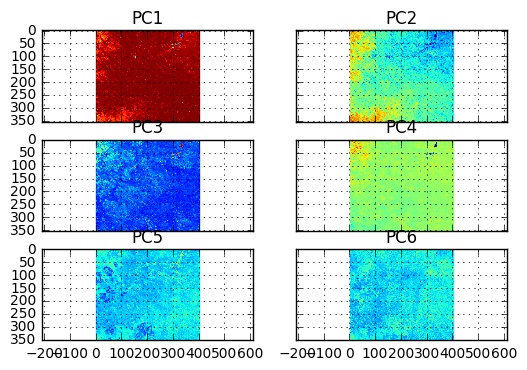

In [12]:
#Now we want to reshape the array back to its original and plot the gri
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')

ax1.imshow(PC_grids['PC1'])
ax1.grid(True)
ax1.set_title('PC1')

ax2.imshow(PC_grids['PC2'])
ax2.grid(True)
ax2.set_title('PC2')

ax3.imshow(PC_grids['PC3'])
ax3.grid(True)
ax3.set_title('PC3')

ax4.imshow(PC_grids['PC4'])
ax4.grid(True)
ax4.set_title('PC4')

ax5.imshow(PC_grids['PC5'])
ax5.grid(True)
ax5.set_title('PC5')

ax6.imshow(PC_grids['PC6'])
ax6.grid(True)
ax6.set_title('PC6')

plt.show()

## Now we want to apply our palaeovaley mask to test for statistical differene inside and outside the valley
This will tell us which PC is best capturing palaeovalleys

In [13]:
# Read in the palaeovalley 2012 shape file
shp = gp.GeoDataFrame.from_file('/g/data/p25/cek156/Palaeovalleys_2012.shp')

In [14]:
# Create a bounding box from the locations specified above
box = shapely.geometry.box(names.minlon[num], names.minlat[num], names.maxlon[num], names.maxlat[num], ccw = True)
# Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
filtered = shp.where(shp.intersects(box)).dropna()
# Combine all of the relevant polygons into a single polygon
shp_union = shapely.ops.unary_union(filtered.geometry)

wanted_keys = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']
Only6 = dict((k, PC_grids[k]) for k in wanted_keys if k in PC_grids)

for idx, item in enumerate(Only6):
    data = PC_grids[item]
    print(item, idx)
    OUTPUT = '/g/data/p25/cek156/' + site + '_PCA_stats.csv'
    
    # Check for the geobox attribute. If it's not there, apply it from the datacube.
    if not hasattr(data, 'geobox'):
        query = {'lat': (names.maxlat[num], names.minlat[num]), 
             'lon': (names.minlon[num], names.maxlon[num]),
             'resolution': (-250, 250), 'output_crs': 'EPSG:3577'}
        elev = dc.load(product = 'srtm_dem1sv1_0', group_by='solar_day', **query)
        print('Applying datacube geobox')
    # Create the mask based on our shapefile
    mask = geometry_mask(warp_geometry(shp_union, shp.crs, elev.crs.wkt), elev.geobox, invert=True)
    # Get data only where the mask is 'true'
    data_masked = data[np.where(mask)]
    # Get data only where the mask is 'false'
    data_maskedF = data[np.where(~ mask)]

    ## Now check for statistical significance
    # Create a new numpy array with just the values
    data_masked2 = np.array(data_masked)
    data_maskedF2 = np.array(data_maskedF)
    # Remove nan values
    data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
    data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
    masked_both = [data_masked_nonan,data_maskedF_nonan]
    
    if data_masked_nonan.any():
    # How many data points are in each of my NDVI lists?
        size = ([len(i) for i in masked_both])
        # Test with a t-test
        stats_ttest, ttest_pval = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
        # Test with a Kolmogorov-Smirnov test 
        # Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
        stats_KS, KS_pval = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)

        # Write to csv file
        row = [item, stats_ttest, stats_KS]
        # Write our stats to a csv file so we can compare them later
        # If this is the first site, make a new file, otherwise, append the existing file
        print('writing to csv')
        write_to_csv(OUTPUT, row, idx)
        # Or if there is no data...
    else:
        print('no useful data')
        row = [item, 'nan', 'nan']
        write_to_csv(OUTPUT, row, idx)

PC3 0
Applying datacube geobox
writing to csv
PC1 1
Applying datacube geobox
writing to csv
PC6 2
Applying datacube geobox
writing to csv
PC5 3
Applying datacube geobox
writing to csv
PC4 4
Applying datacube geobox
writing to csv
PC2 5
Applying datacube geobox
writing to csv


## Print graph for our example site

  name       ttest   KS_test
1  PC1  -31.664623  0.115027
5  PC2 -117.054527  0.377084
0  PC3   -8.599214  0.116483
4  PC4   -5.261224  0.123835
3  PC5   14.297184  0.055904
2  PC6   -7.112875  0.042239


(1, -1)

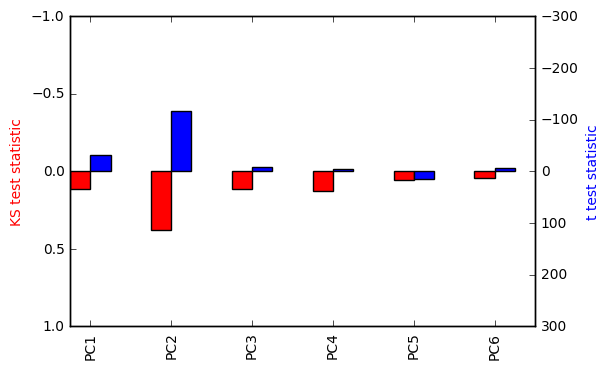

In [15]:
#Read in the CSV with the stats

PC_stats = pandas.read_csv(OUTPUT)

# Sort the data alphabetically
PC_stats = PC_stats.sort_values(by = 'name')
print(PC_stats)

# Setting the positions and width for the bars
pos = list(range(len(PC_stats.ttest)))
width = 0.25

fig = plt.figure()

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

PC_stats.KS_test.plot(kind='bar', color='red', ax=ax, width=width, position=1)
PC_stats.ttest.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

# Set the y axis label
ax.set_ylabel('KS test statistic', color='red')
ax2.set_ylabel('t test statistic', color='blue')

# Set the labels for the x ticks
ax.set_xticklabels(PC_stats['name'])

# Setting the x-axis and y-axis limits

ax2.set_ylim([300, -300])
ax.set_ylim([1, -1])

#Let's save the plot
#fig.savefig('/g/data/p25/cek156/' + keys + '_stats.jpg', bbox_inches='tight')